In [1]:
%matplotlib inline
from utils import *
from tqdm import *
from os.path import join
from matplotlib import pyplot as plt
from skimage.measure import block_reduce
from multiprocessing import Pool
import numpy as np
import librosa

In [2]:
data_root = 'drumData'
n_fft = 1024
hop_length = n_fft/4
use_logamp = False # boost the brightness of quiet sounds
reduce_rows = 10 # how many frequency bands to average into one
reduce_cols = 1 # how many time steps to average into one
crop_rows = 32 # limit how many frequency bands to use
crop_cols = 32 # limit how many time steps to use
limit = None # set this to 100 to only process 100 samples

In [3]:
drumNames = ["kick", "tom", "snare", "clap", "hi.hat", "ride", "crash"]
drumFingerPrints = {}
drumSamples = {}
for d in drumNames:
    %time drumSamples[d] = np.load(join(data_root, d+'_samples.npy'))

CPU times: user 950 µs, sys: 145 ms, total: 146 ms
Wall time: 144 ms
CPU times: user 838 µs, sys: 12.6 ms, total: 13.4 ms
Wall time: 13.2 ms
CPU times: user 708 µs, sys: 65.7 ms, total: 66.4 ms
Wall time: 66.1 ms
CPU times: user 642 µs, sys: 33.9 ms, total: 34.5 ms
Wall time: 34.3 ms
CPU times: user 960 µs, sys: 5.78 ms, total: 6.74 ms
Wall time: 6.32 ms
CPU times: user 842 µs, sys: 6.94 ms, total: 7.78 ms
Wall time: 7.41 ms
CPU times: user 619 µs, sys: 20.7 ms, total: 21.3 ms
Wall time: 21.1 ms


In [4]:
crashes = drumSamples["crash"]
kicks = drumSamples["kick"]

# Feature Extraction Pipeline

In [6]:
# Librosa does not support computing spectral crest nor spectral flux,
# so we write our own function based on MIR assignment 2
def computeSpectralCrest(sample):
    sample_fft = librosa.core.stft(sample, hop_length=512) 
    sample_fft = np.abs(sample_fft)
    numBlocks = sample_fft.shape[1]
    spectral_crest = np.zeros((1,numBlocks))
    for i in range(numBlocks):
        blockFFT = sample_fft[:,i]
        spectral_crest[:,i] = np.max(blockFFT) / np.sum(blockFFT)
    return spectral_crest

def computeSpectralFlux(sample):
    sample_fft = librosa.core.stft(sample, hop_length=512) 
    sample_fft = np.abs(sample_fft)
    (blockSize, numBlocks) = sample_fft.shape
    spectral_flux = np.zeros((1,numBlocks))
    spectral_flux[0] = 0 # Set flux at 0 for very first timestep
    for i in range(1,numBlocks):
        spectral_diff = sample_fft[:,i] - sample_fft[:,i-1]
        spectral_flux[:,i] = np.sqrt(np.sum(np.square(spectral_diff))) / (blockSize) # in MATLAB version we do blockSize/2 because MATLAB does not automatically halve and discard the spectrum for us
    return spectral_flux

In [9]:
def extractFeatures(sample):
    num_features = 6 # RMS, spectral centroid, spectral crest, spectral flux, zero crossing, spectral rolloff
    num_blocks = 24 # Our samples are each 12000 samples long, so there are 24 blocks with 512 hopsize
    # TODO: create a config file that passes sr = 48000 to all processing pipelines
    sr = 48000 
    feature_matrix = np.zeros((num_features,num_blocks))
    
    # RMS
    feature_matrix[0,:] = librosa.feature.rmse(y=sample)
    
    # Spectral Centroid 
    feature_matrix[1,:] = librosa.feature.spectral_centroid(y=sample, sr=sr)
    
    # Spectral Crest 
    feature_matrix[2,:] = computeSpectralCrest(sample)
    
    # Spectral Flux 
    feature_matrix[3,:] = computeSpectralFlux(sample)
    
    # Spectral Roll-off
    feature_matrix[4,:] = librosa.feature.spectral_rolloff(sample)
    
    # Zerocrossing Rate
    feature_matrix[5,:] = librosa.feature.zero_crossing_rate(y=sample)
    
    return feature_matrix

#### Sanity check on feature extraction pipeline

In [21]:
def plotFeatures(original_sample, feature_matrix):
    (num_features, num_blocks) = feature_matrix.shape
    feature_dict = ["RMS","Spectral Centroid","Spectral Crest","Spectral Flux","Spectral Roll-off","Zerocrossing Rate"]

    plt.figure()
    plt.plot(original_sample)
    plt.title("Original Sample")

    for i in range(num_features):
        feature = feature_matrix[i,:]
        plt.figure()
        plt.plot(feature.T)  # have to transpose to correctly show data
        plt.title(feature_dict[i])

In [22]:
sample_kick = kicks[0]
sample_crash = crashes[0]

#### Testing on a kick

/Users/lamtharnhantrakul/anaconda/envs/klustr/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in float_scalars
  # Remove the CWD from sys.path while we load stuff.


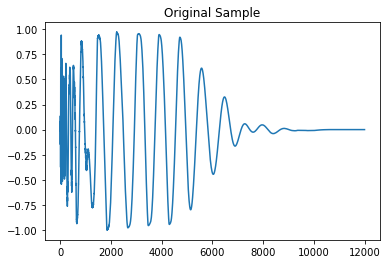

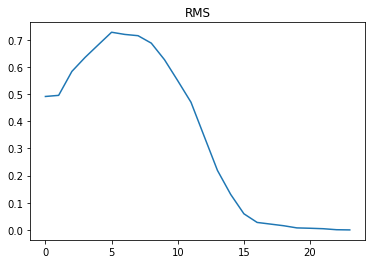

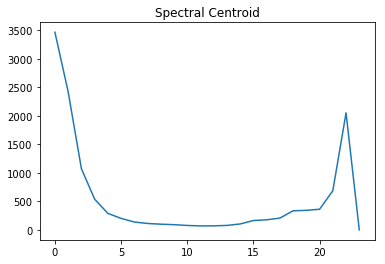

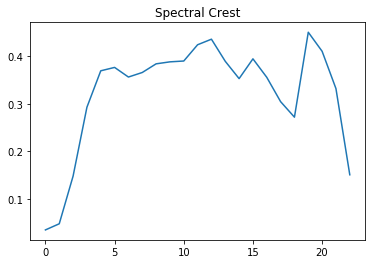

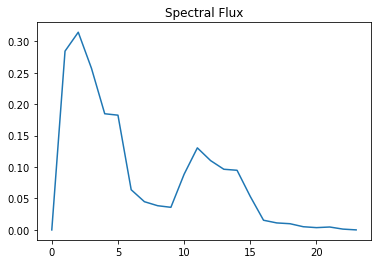

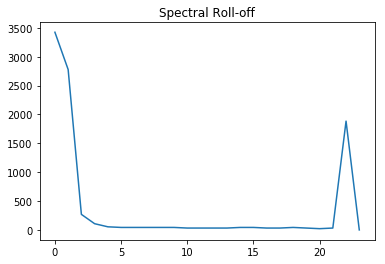

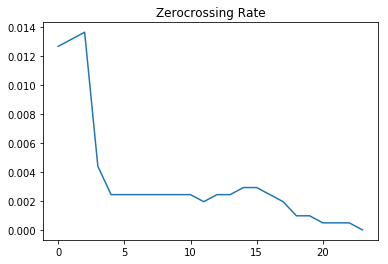

In [23]:
kick_feature_matrix = extractFeatures(sample_kick)
plotFeatures(sample_kick, kick_feature_matrix)

#### Testing on a crash

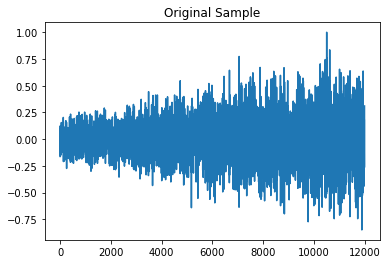

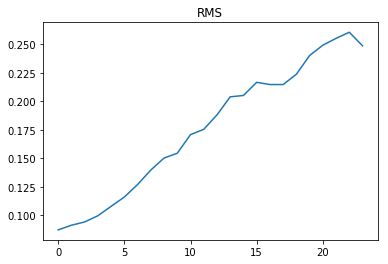

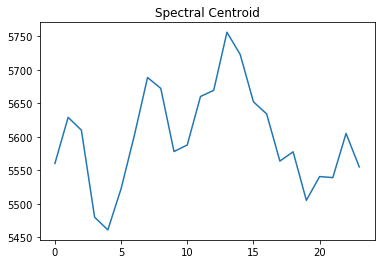

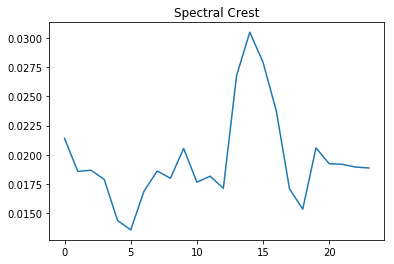

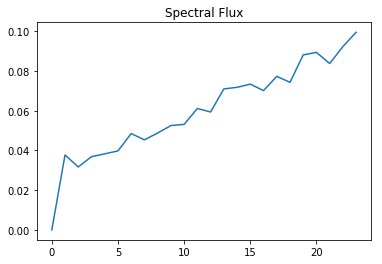

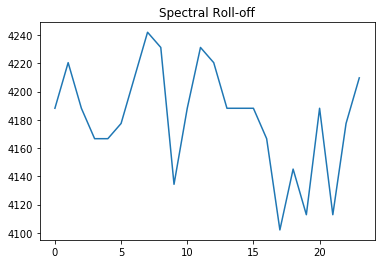

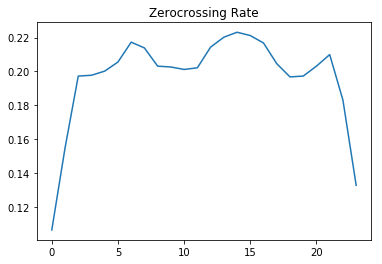

In [24]:
crash_feature_matrix = extractFeatures(sample_crash)
plotFeatures(sample_crash,crash_feature_matrix)